## Mask R-CNN - Inspect Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [78]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Root directory to hdd
DATA_DIR = os.path.abspath("/data/hdd")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

import mrcnn.model as modellib
from mrcnn import data_generator
from mrcnn import utils
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.load_weights import load_weights

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(DATA_DIR, "russales", "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MODEL_DIR, "coco20190111T1814", "mask_rcnn_coco_0080.h5")

## Configurations

In [79]:
# MS COCO Dataset
import coco
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
KEYPOINT_LOSS_WEIGHTING        True
KEYPOINT_MASK_POOL_SIZE        7
KEYPOINT_MASK_SHAPE            [56, 56]
KEYPOINT_THRESHOLD             0.005
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LIMBS                          [0, -1, -1, 5, -1, 6, 5, 7, 6

## Notebook Preferences

In [80]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [81]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [82]:
# path to MSCOCO dataset
COCO_DIR = os.path.join(DATA_DIR, "Datasets", "MSCOCO_2017")

# Initialize Dataset, call prepare to use 
dataset = coco.CocoDataset(task_type="person_keypoints")
dataset.load_coco(COCO_DIR, "val", "2017", class_ids=[1], auto_download=False)
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!
Skeleton: (19, 2)
Keypoint names: (17,)
Images: 2693
Classes: ['BG', 'person']


## Load Model

In [83]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR)

# Load weights
print("Loading weights ", COCO_MODEL_PATH)
load_weights(model, COCO_MODEL_PATH, by_name=True, include_optimizer=False)

Loading weights  /data/hdd/russales/logs/coco20190111T1814/mask_rcnn_coco_0080.h5
Re-starting from epoch 80


## Run Detection

In [84]:
# load image and ground truth data
dg = data_generator.DataGenerator(dataset, config, shuffle=True, batch_size=config.BATCH_SIZE)

# image ids on val set 
#image_id = 1041 # single woman 
#image_id = 2401 # baseball game 
image_id = 770 # woman on street
#image_id = random.choice(dataset.image_ids)

image, image_meta, gt_class_ids, gt_boxes, gt_masks, gt_keypoints = \
    dg.load_image_gt(image_id, augmentation=None, use_mini_mask=False)

info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

image ID: coco.198928 (770) http://cocodataset.org/#explore?id=198928


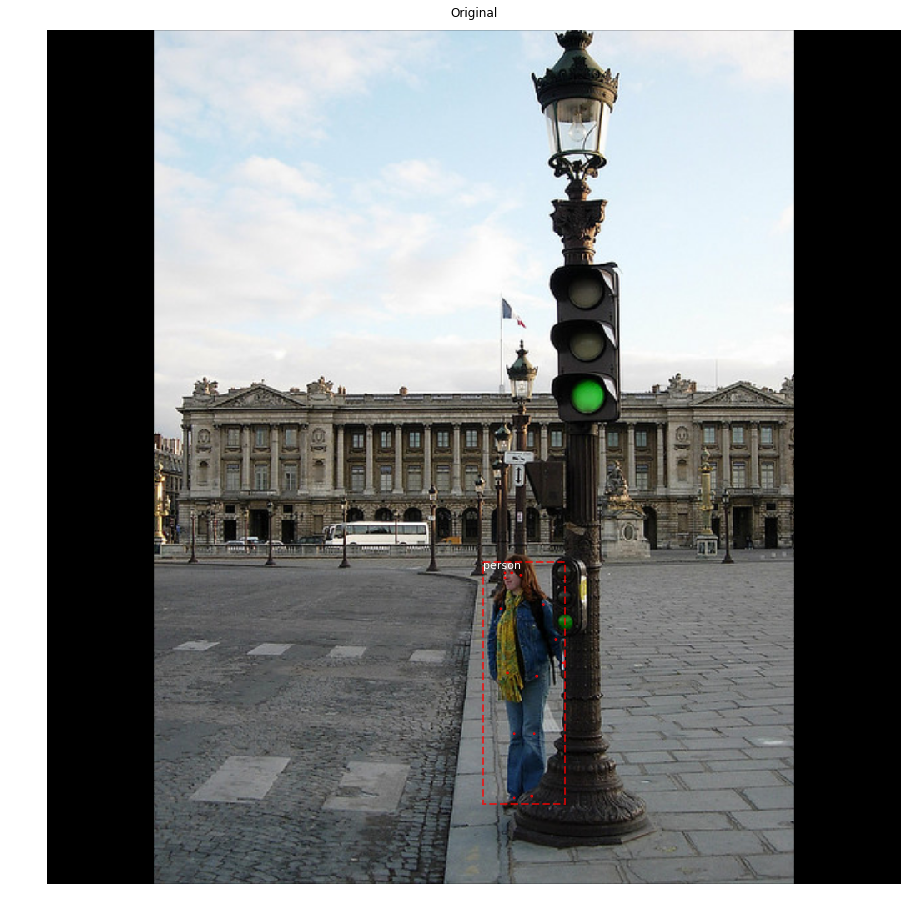

In [85]:
# display original image with annotations

ax = get_ax(1)
visualize.display_keypoints(image, gt_boxes, gt_keypoints, gt_class_ids, dataset.class_names,
                            ax=ax, title="Original")

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
windows                  shape: (1, 4)                min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
------ Predictions ----------
detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
mrcnn_class              shape: (1, 1000, 2)          min:    0.00000  max:    1.00000  float32
mrcnn_bbox               shape: (1, 1000, 2, 4)       min:   -3.71353  max:    2.94491  float32
rois                     shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000  floa

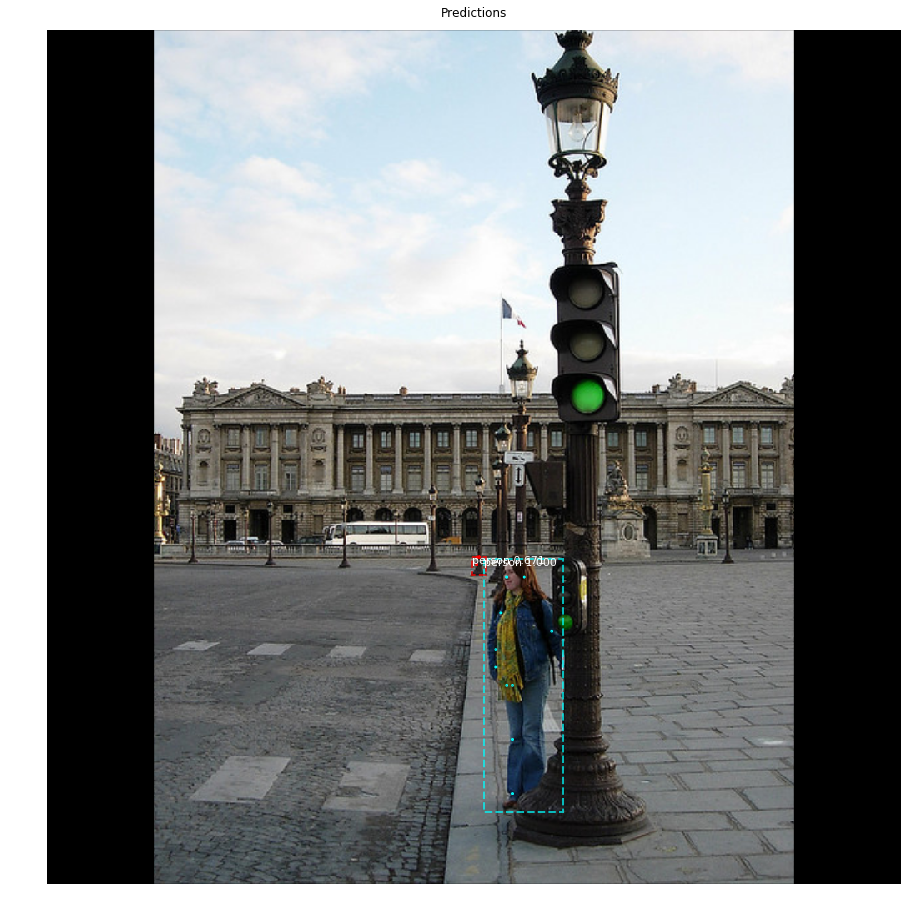

In [86]:
# Run object detection for masks 
# results = model.detect([image], verbose=1)

# Run object detection for masks and keypoints
results = model.detect_keypoint([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]

bboxes_result = r['bboxes']
masks_result = r['masks']
class_ids_result = r['class_ids']
scores_result = r['scores']
keypoints_result = r['keypoints']

visualize.display_keypoints(image, bboxes_result, keypoints_result, class_ids_result, dataset.class_names,
                         scores=scores_result , ax=ax, title="Predictions")

#visualize.display_instances(image, rois_result, masks_result, class_ids_result, 
#                            dataset.class_names, scores_result, ax=ax, title="Predictions")

### Precision-Recall

gt_masks input:  (1024, 1024, 1)
pred_mask input:  (1024, 1024, 2)
gt_masks:  (1024, 1024, 1)
pred_mask:  (1024, 1024, 2)


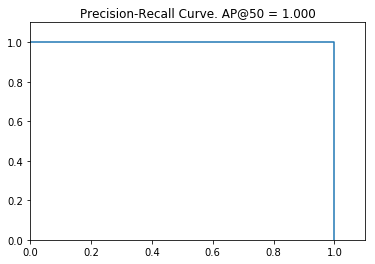

In [87]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_boxes, gt_class_ids, gt_masks, 
                                                     bboxes_result, class_ids_result, scores_result, masks_result)
visualize.plot_precision_recall(AP, precisions, recalls)

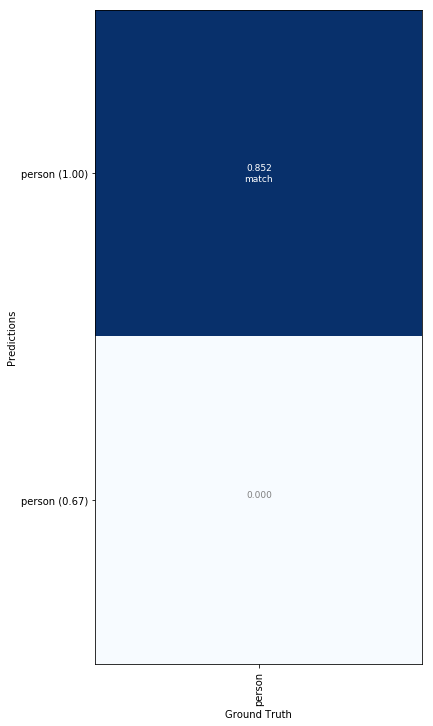

In [88]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_ids, class_ids_result, scores_result,
                        overlaps, dataset.class_names)

### Compute mAP @ IoU=50 on Batch of Images

In [89]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_keypoint = \
            dg.load_image_gt(image_id, augmentation=None, use_mini_mask=False)
        # Run object detection
        results = model.detect_keypoint([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['bboxes'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 10)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

gt_masks input:  (1024, 1024, 1)
pred_mask input:  (1024, 1024, 1)
gt_masks:  (1024, 1024, 1)
pred_mask:  (1024, 1024, 1)
gt_masks input:  (1024, 1024, 1)
pred_mask input:  (1024, 1024, 1)
gt_masks:  (1024, 1024, 1)
pred_mask:  (1024, 1024, 1)
gt_masks input:  (1024, 1024, 1)
pred_mask input:  (1024, 1024, 4)
gt_masks:  (1024, 1024, 1)
pred_mask:  (1024, 1024, 4)
gt_masks input:  (1024, 1024, 1)
pred_mask input:  (1024, 1024, 1)
gt_masks:  (1024, 1024, 1)
pred_mask:  (1024, 1024, 1)
gt_masks input:  (1024, 1024, 3)
pred_mask input:  (1024, 1024, 3)
gt_masks:  (1024, 1024, 3)
pred_mask:  (1024, 1024, 3)
gt_masks input:  (1024, 1024, 1)
pred_mask input:  (1024, 1024, 2)
gt_masks:  (1024, 1024, 1)
pred_mask:  (1024, 1024, 2)
gt_masks input:  (1024, 1024, 1)
pred_mask input:  (1024, 1024, 1)
gt_masks:  (1024, 1024, 1)
pred_mask:  (1024, 1024, 1)
gt_masks input:  (1024, 1024, 5)
pred_mask input:  (1024, 1024, 12)
gt_masks:  (1024, 1024, 5)
pred_mask:  (1024, 1024, 12)
gt_masks input:  (1024

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [90]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = dg.build_rpn_targets(gt_class_ids, gt_boxes)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (150, 4)              min:   -0.49718  max:    2.56879  float64
positive_anchors         shape: (1, 4)                min:  530.74517  max:  826.50967  float64
negative_anchors         shape: (149, 4)              min:  -22.62742  max: 1042.62742  float64
neutral anchors          shape: (261738, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (1, 4)                min:  522.00000  max:  928.00000  float32


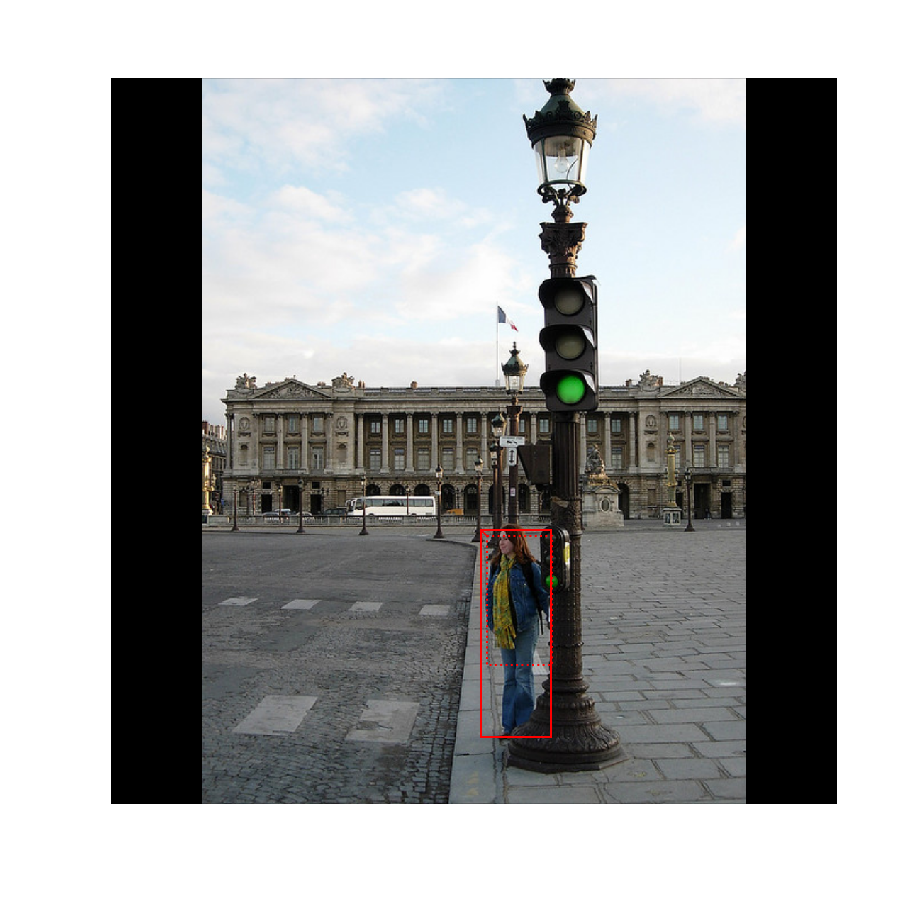

In [91]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [94]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.04109  max:    1.16622  float32
refined_anchors          shape: (1, 6000, 4)          min:   -0.87610  max:    1.92809  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 1740.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


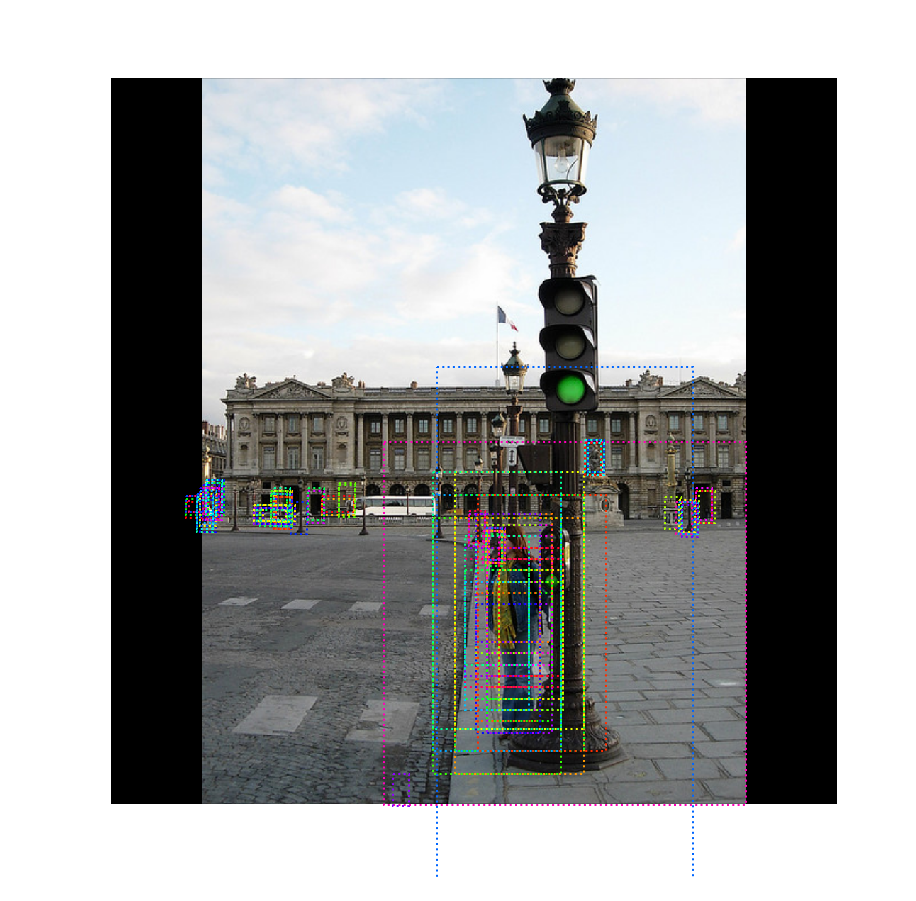

In [95]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

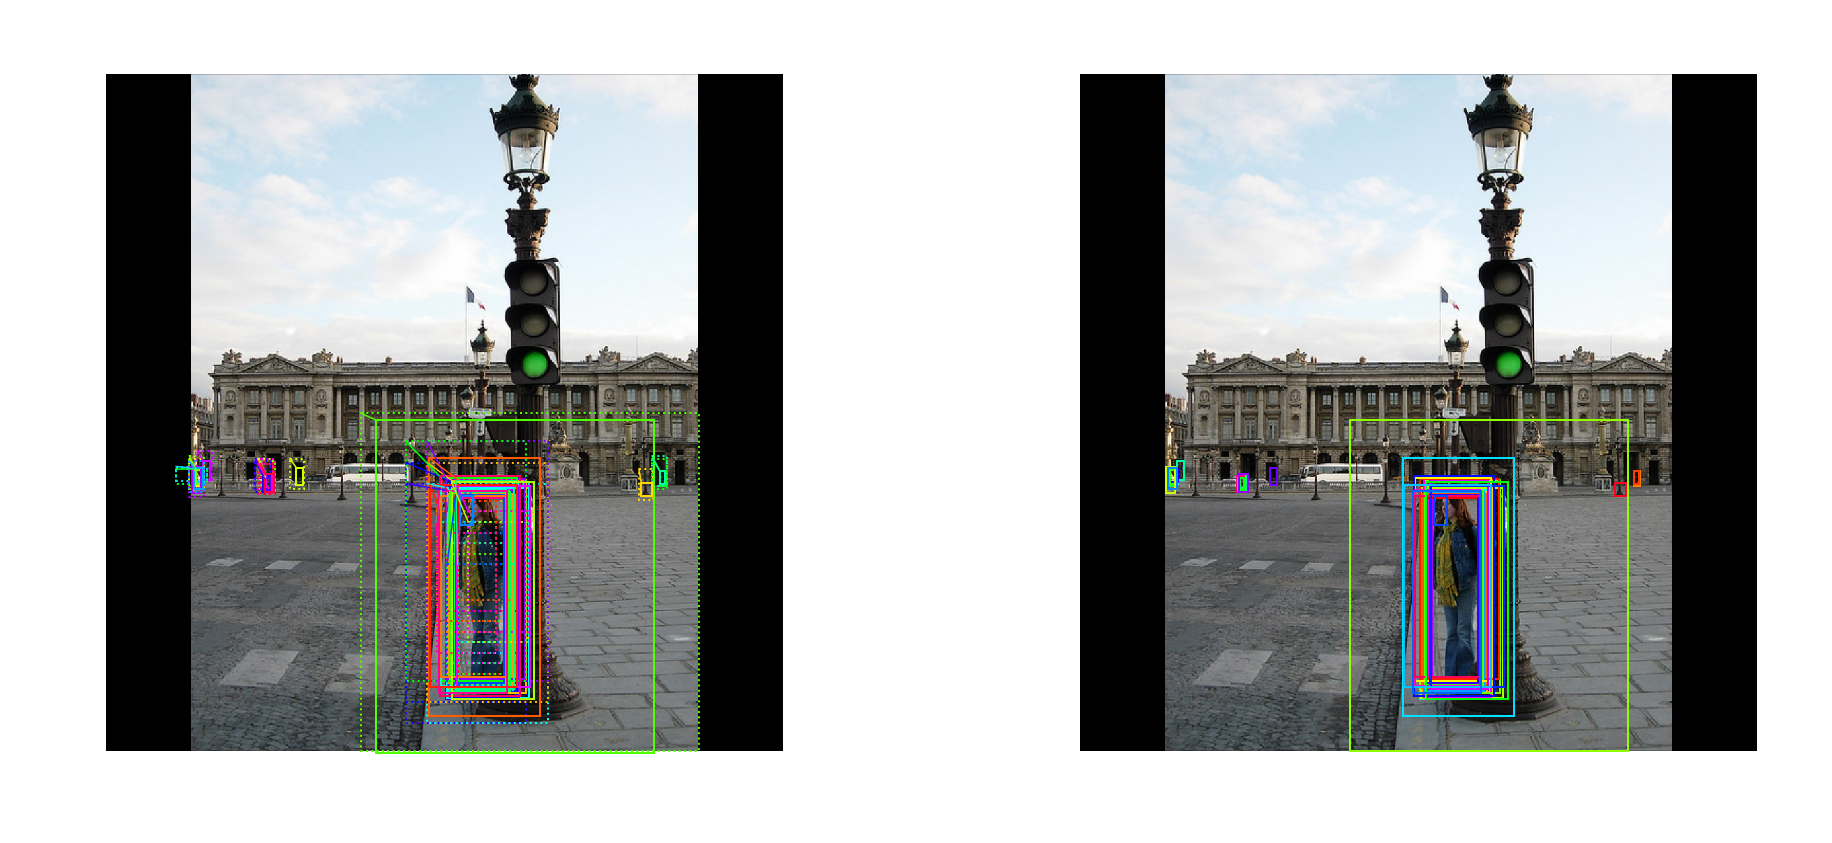

In [96]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

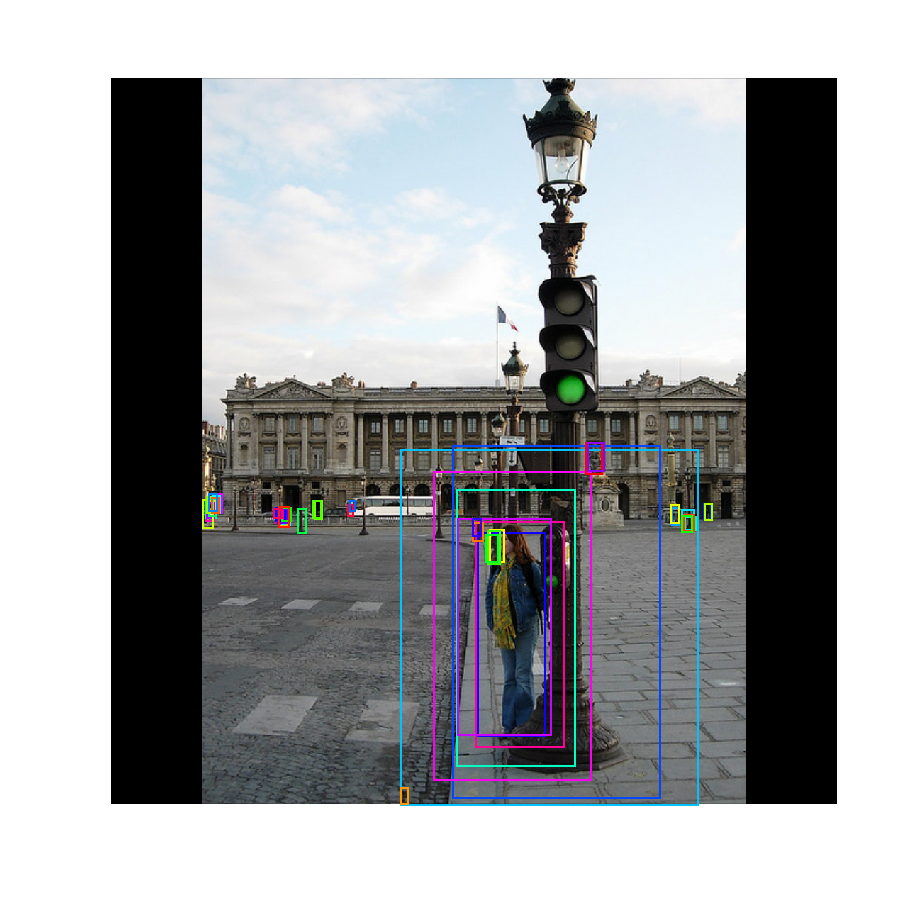

In [97]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

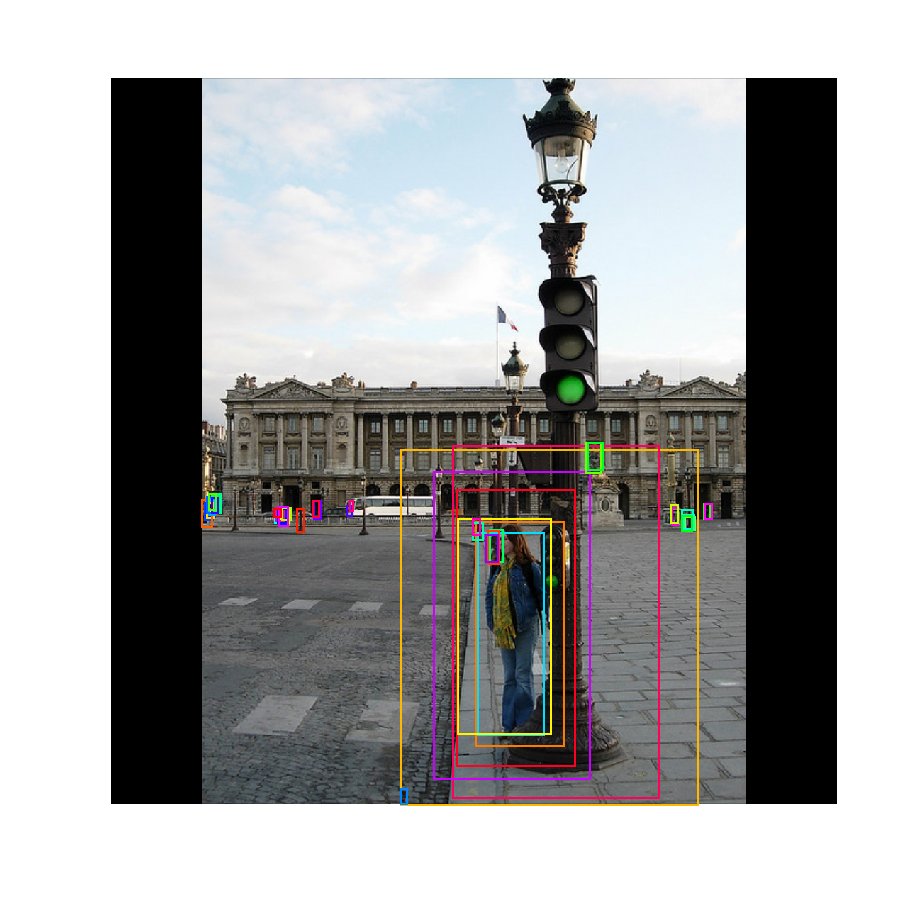

In [98]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [100]:
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7

recall, positive_anchor_ids = utils.compute_recall(model.anchors, gt_boxes, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(rpn['refined_anchors'][0], gt_boxes, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(proposals, gt_boxes, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))


All Anchors (261888)       Recall: 0.000  Positive anchors: 0
Refined Anchors ( 6000)   Recall: 0.000  Positive anchors: 0
Post NMS Anchors (   50)  Recall: 1.000  Positive anchors: 3


## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [104]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("keypoints", model.keras_model.get_layer("mrcnn_keypoint_mask_reshape").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 2)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 2, 4)       min:   -3.71353  max:    2.94491  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00014  max:    0.99866  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
keypoints                shape: (1, 100, 17, 3136)    min:  -25.44134  max:    7.84714  float32


2 detections: ['person' 'person']


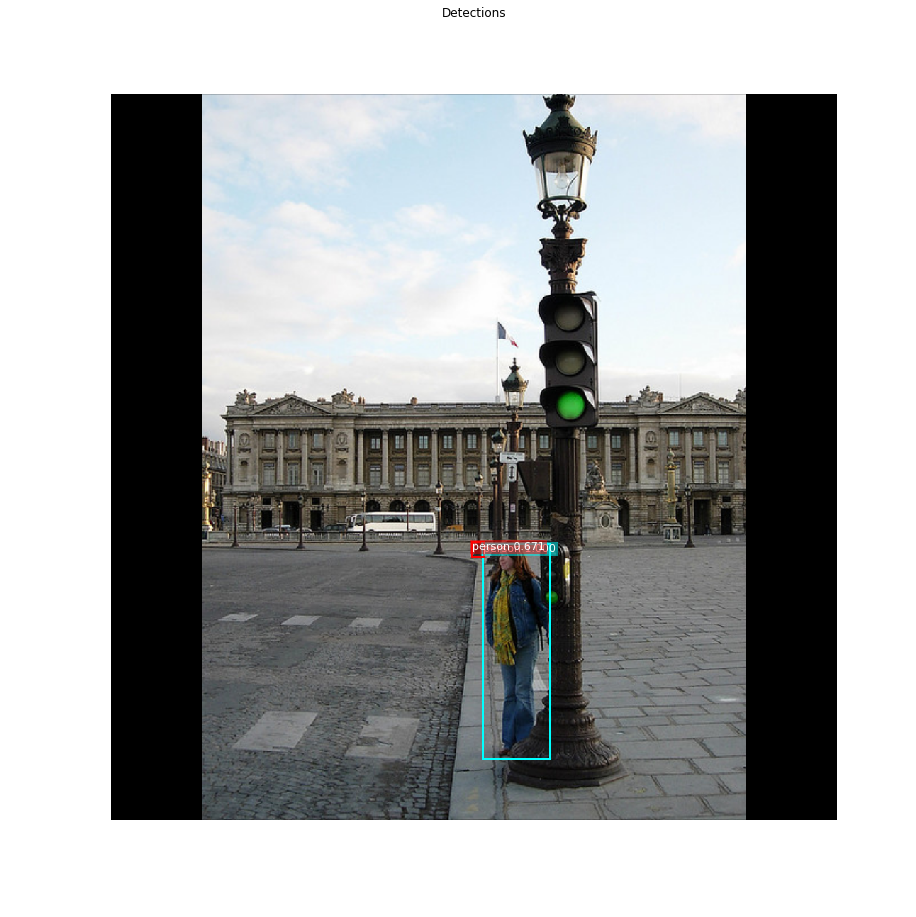

In [105]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [106]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
9 Positive ROIs
[('BG', 991), ('person', 9)]


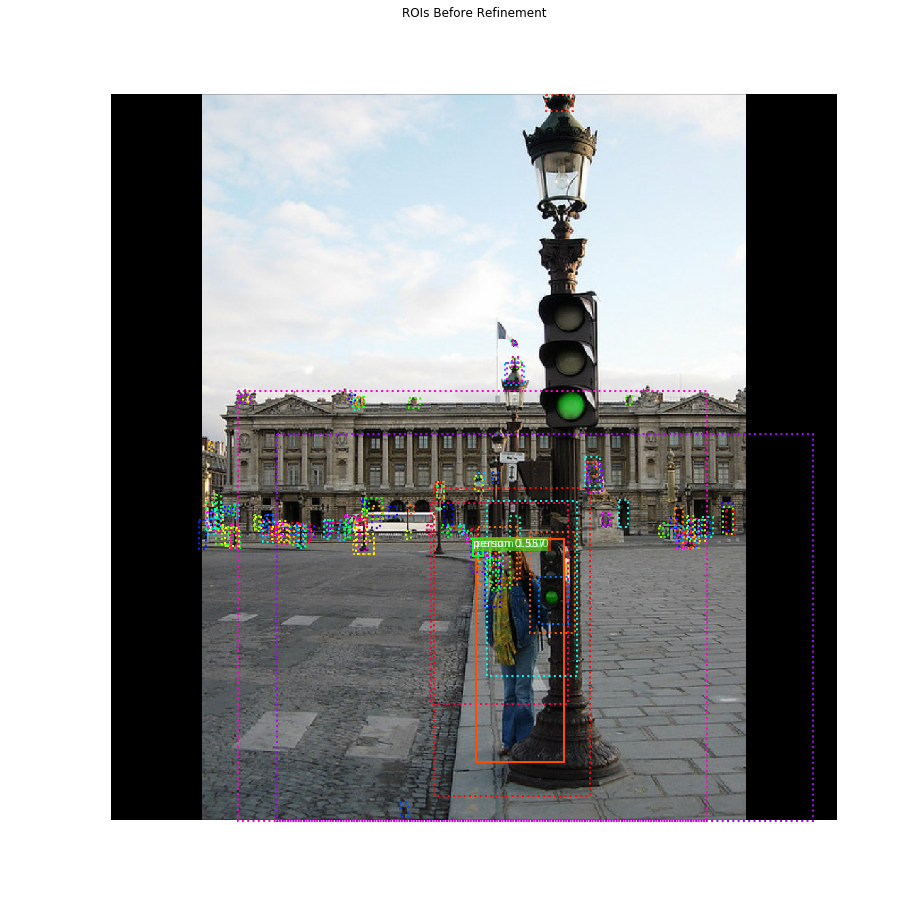

In [107]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -3.71353  max:    2.52894  float32
refined_proposals        shape: (1000, 4)             min:  -20.00000  max: 1040.00000  int32


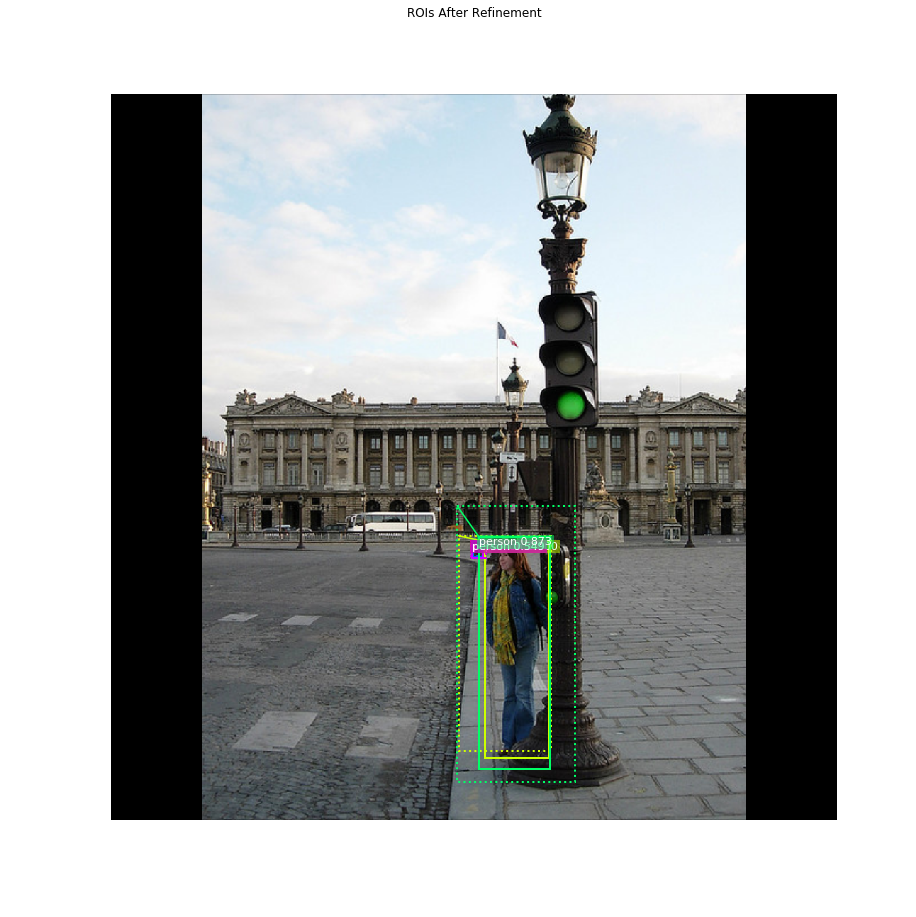

In [108]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [109]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 9 detections:
[  0   1   4  11  19  67 109 215 230]


In [110]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0 confidence. Keep 9:
[  0   1   4  11  19  67 109 215 230]


#### Per-Class Non-Max Suppression

In [111]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

person                : [  0   1   4  11  19  67 109 215 230] -> [  0 215]

Kept after per-class NMS: 2
[  0 215]


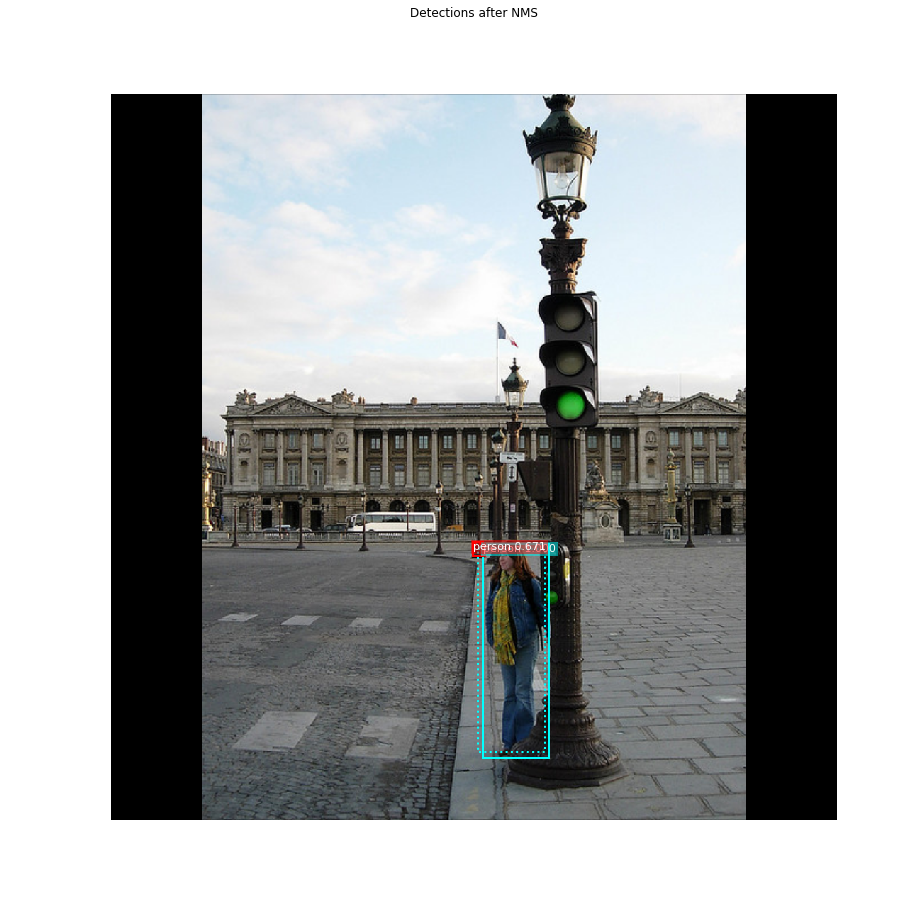

In [112]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

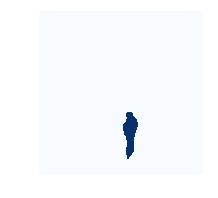

In [116]:
visualize.display_images(np.transpose(gt_masks, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [117]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00014  max:    0.99866  float32
2 detections: ['person' 'person']


In [118]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (2, 28, 28)           min:    0.00014  max:    0.99866  float32
det_masks                shape: (2, 1024, 1024)       min:    0.00000  max:    1.00000  bool


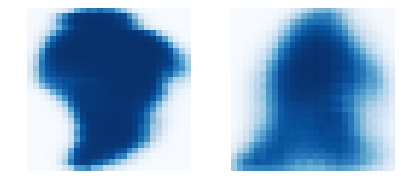

In [120]:
visualize.display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

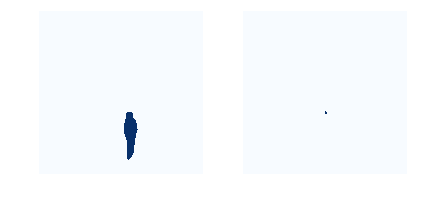

In [121]:
visualize.display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [141]:

# Get activations of a few sample layers
activations = model.run_graph([image], [
#    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res5c_out",          model.keras_model.get_layer("res5c_out").output),  # for resnet50
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

res5c_out                shape: (1, 32, 32, 2048)     min:    0.00000  max:   59.73148  float32
rpn_bbox                 shape: (1, 261888, 4)        min:  -13.85218  max:  143.42586  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


In [142]:
# Input image (normalized)
#_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f5df42046d8>>
Traceback (most recent call last):
  File "/home/russales/envs/tf1-12-gpu/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/russales/envs/tf1-12-gpu/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 316419056
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f5df4204c88>>
Traceback (most recent call last):
  File "/home/russales/envs/tf1-12-gpu/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)

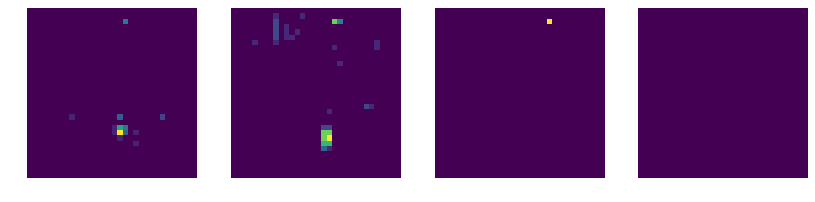

In [143]:
# Backbone feature map
visualize.display_images(np.transpose(activations["res5c_out"][0,:,:,:4], [2, 0, 1]))

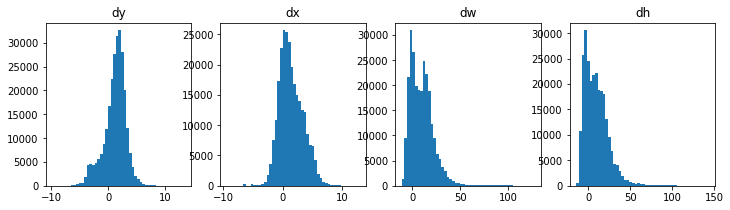

In [144]:
# Histograms of RPN bounding box deltas
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

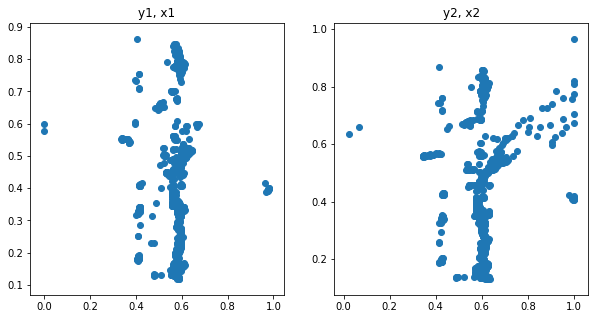

In [145]:
# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()